In [106]:
# We're going to start off in a jupyter notebook and slowly move this into a widget... for visualization with tests and stuff
#%matplotlib 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from functools import reduce
from operator import concat
import glob

import pandas as pd

import seaborn as sns
sns.set_theme()

In [107]:

def find_walks_with_type(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    walkNum = walks
    return walkNum


def load_data(ID,walkNum):


    footholds = []
    gazeGround = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')    
        marker,skeleton,fholds,gGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        footholds.append(fholds)
        gazeGround.append(gGround)
        hips = np.squeeze(skeleton[:,1,:])
    return footholds, gazeGround




def distances_closest_current(footholds,gazeGround):

    current_foothold = []
    closest_foothold= []
    distances = []
    for x,y in zip(footholds,gazeGround):
        frame_edges = np.append(np.append(1,x[:,0]),y.shape[0]+1)
        frames_per_foothold = np.diff(frame_edges)
        current = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))
        current_foothold.append(current)

        d = cdist(y,x[:,2:])
        distances.append(d)

        closest= np.argmin(d,axis=1)+1
        closest_foothold.append(closest)

    return distances, closest_foothold, current_foothold




def find_rel_foothold_fixation(distances, closest_foothold, current_foothold):

    rel_foothold_fixation = []
    for x,y,z in zip (distances, closest_foothold, current_foothold):
            distances_min= np.min(x, axis = 1)
        
            rff = np.where(distances_min > 0.4, np.nan, y-z)
            rel_foothold_fixation.append(rff)
        
    rel_foothold_fixation = np.hstack(rel_foothold_fixation)
    five_steps = [x for x in rel_foothold_fixation if np.abs(x) < 6 and np.abs(x) > 0]
    return rel_foothold_fixation,five_steps

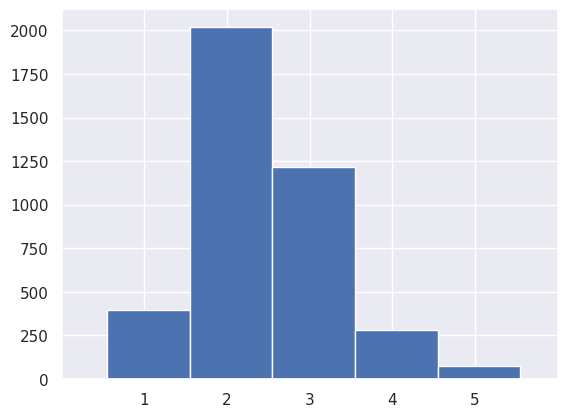

In [108]:
walkNum = find_walks_with_type(3,'rock')
footholds,gazeGround = load_data(3,walkNum)
distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
plt.hist(steps, bins= np.arange(np.nanmin(steps)-.95,
               np.nanmax(steps)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.show()


In [109]:
#pooling the relative foothold fixations in each subject for each walk type


rel_foothold_fixation_rock = []
rock_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'rock')
    footholds,gazeGround = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_rock.append(rel_foothold_fixation)
    rock_steps.append(steps)


rel_foothold_fixation_medium = []
medium_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'medium')
    footholds,gazeGround = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_medium.append(rel_foothold_fixation)
    medium_steps.append(steps)


rel_foothold_fixation_flat = []
flat_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'flat')
    footholds,gazeGround = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_flat.append(rel_foothold_fixation)
    flat_steps.append(steps)



In [110]:
#s6_23 is missing

rel_foothold_fixation_pavement= []
pavement_steps = []
for x in range(3,6):
    walkNum = find_walks_with_type(x,'pavement')
    footholds,gazeGround = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_pavement.append(rel_foothold_fixation)
    pavement_steps.append(steps)
for x in range(7,11):
    walkNum = find_walks_with_type(x,'pavement')
    footholds,gazeGround = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_pavement.append(rel_foothold_fixation)
    pavement_steps.append(steps)

data = sio.loadmat('/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh/s6_2_pupilShadowMesh.mat')    
marker,skeleton,footholds,gazeGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
hips = np.squeeze(skeleton[:,1,:])
frame_edges = np.append(np.append(1,footholds[:,0]),gazeGround.shape[0]+1)
frames_per_foothold = np.diff(frame_edges)
current_foothold = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))
distances = cdist(gazeGround,footholds[:,2:])
closest_foothold= np.argmin(distances,axis=1)+1
distances_min= np.min(distances, axis = 1)
rel_foothold_fixation = np.where(distances_min > 0.4, np.nan, closest_foothold-current_foothold)
five_steps = [x for x in rel_foothold_fixation if np.abs(x) < 6 and np.abs(x) > 0]
rel_foothold_fixation_pavement.append(rel_foothold_fixation)
pavement_steps.append(steps)


    



    

In [111]:
def plot_par(rows,cols,n,steps):
    plt.subplot(rows,cols,n)
    plt.hist(steps[i], bins= np.arange(np.nanmin(steps[i])-.95,
               np.nanmax(steps[i])+ .95,1), align = 'right', rwidth = 1.88)
    plt.xlim(0,6)
    plt.xticks(np.arange(1,6,1))
    


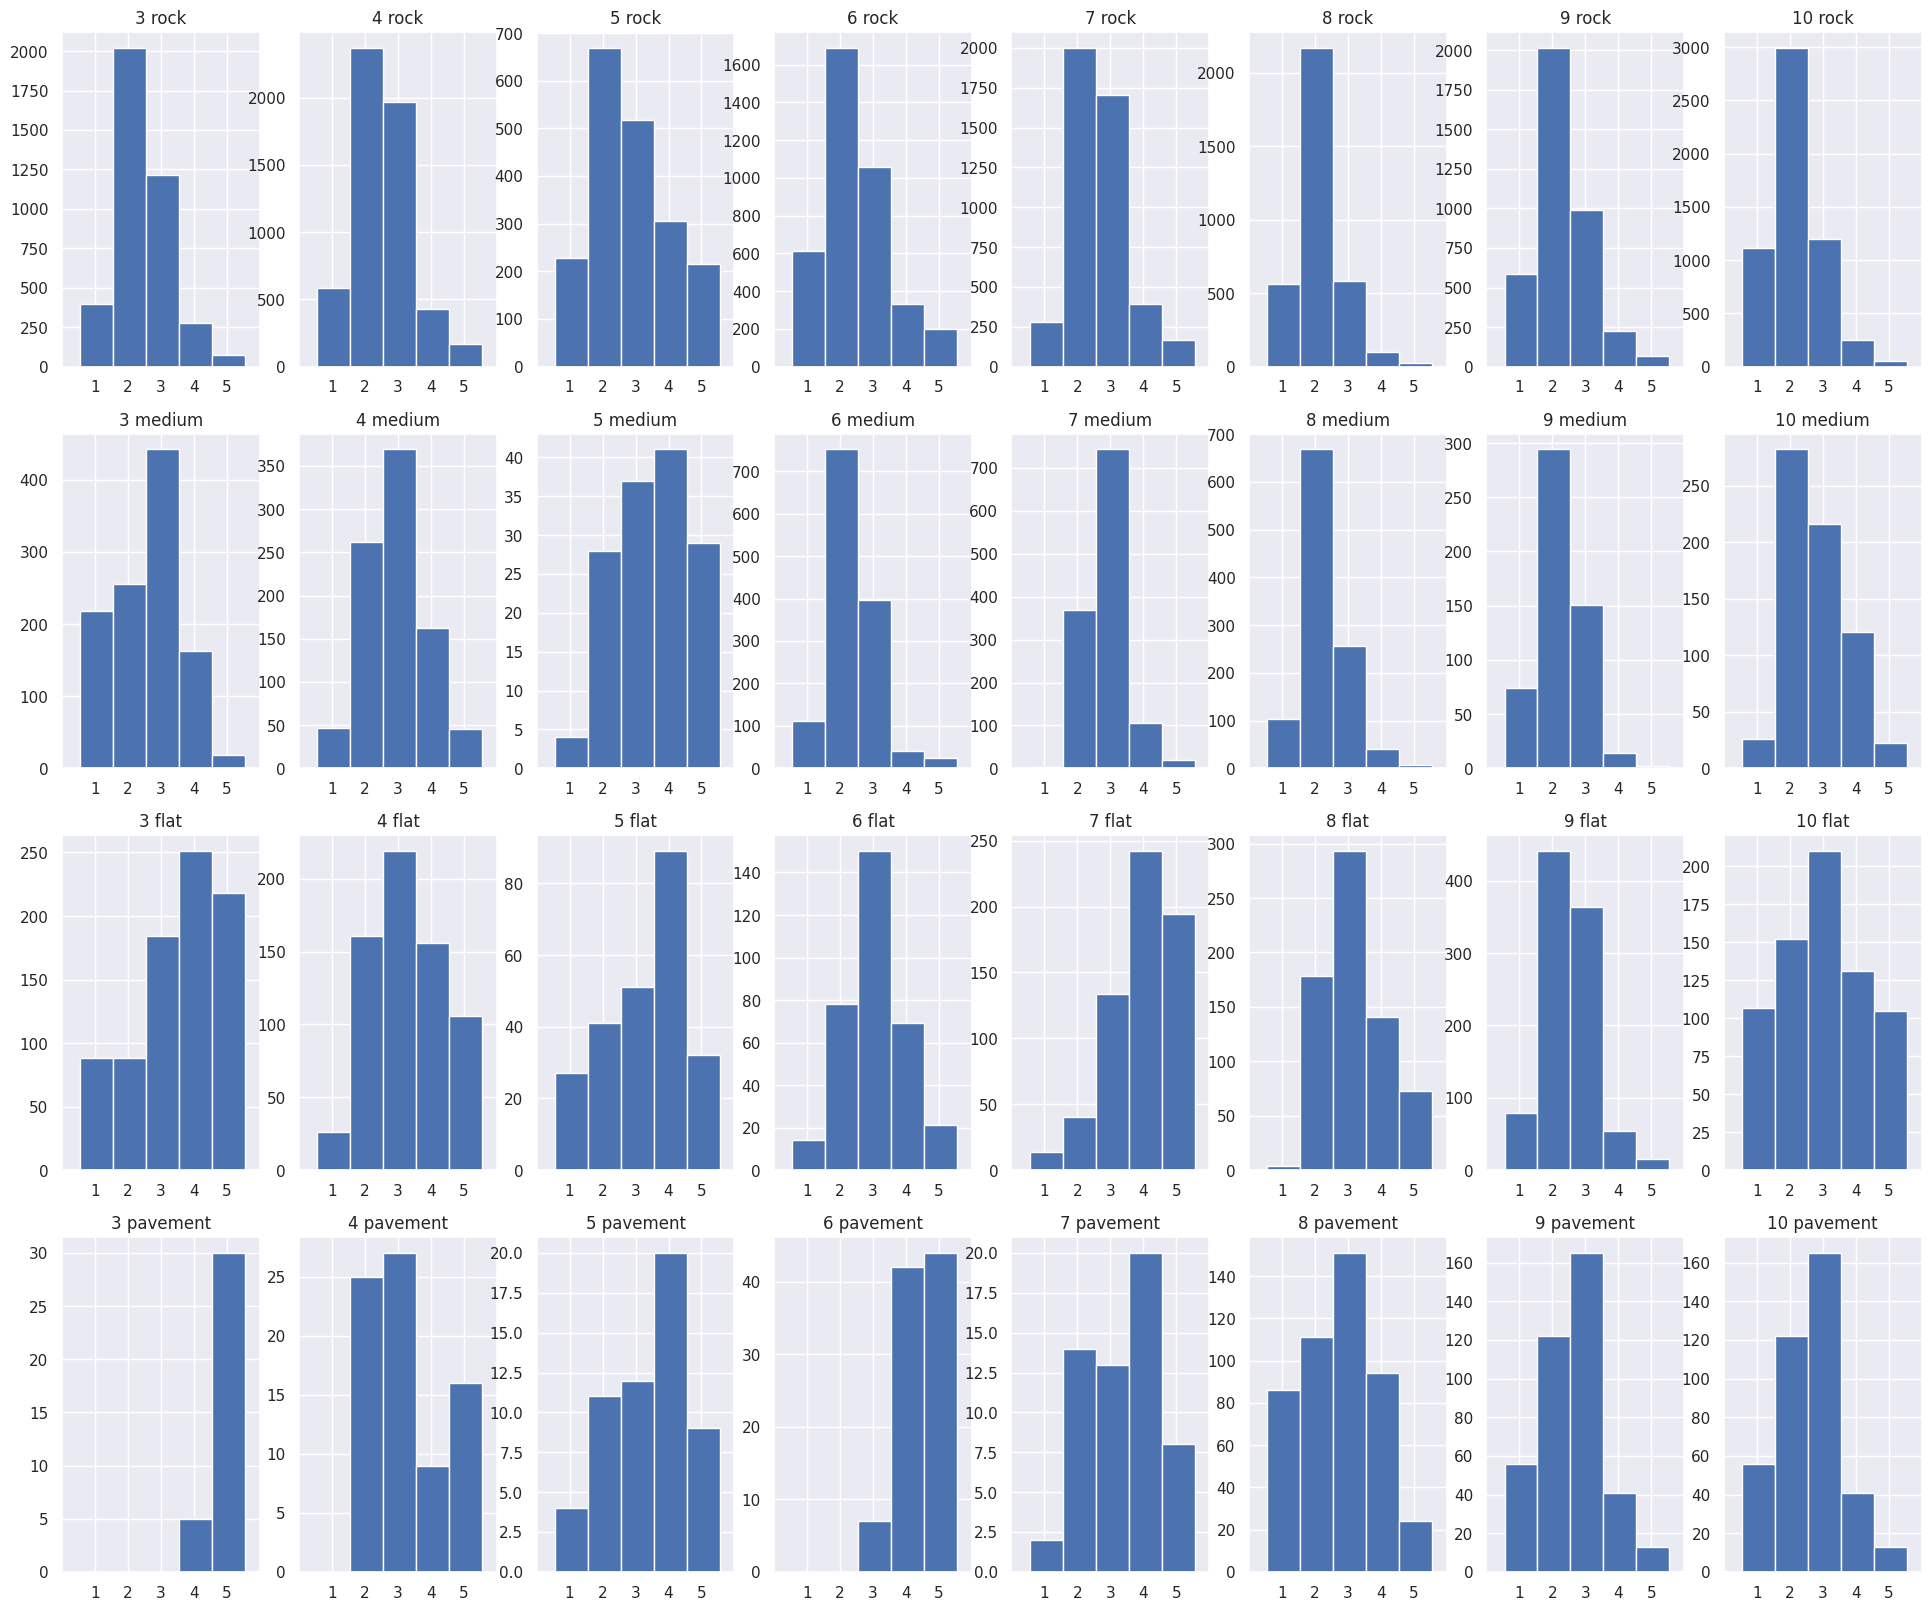

In [112]:
plt.figure(figsize=(24,20))

s = 2
for i in range(len(rock_steps)):
    n = i +1
    s +=1
    plot_par(4,8,n,rock_steps)
    plt.title(f'{s} rock')

s = 2   
n = 8
for i in range(len(medium_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,medium_steps)
    plt.title(f'{s} medium')


s = 2
n = 16
for i in range(len(flat_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,flat_steps)
    plt.title(f'{s} flat')
    
s = 2
n = 24
for i in range(len(pavement_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,pavement_steps)
    plt.title(f'{s} pavement')


plt.tight_layout

plt.show()

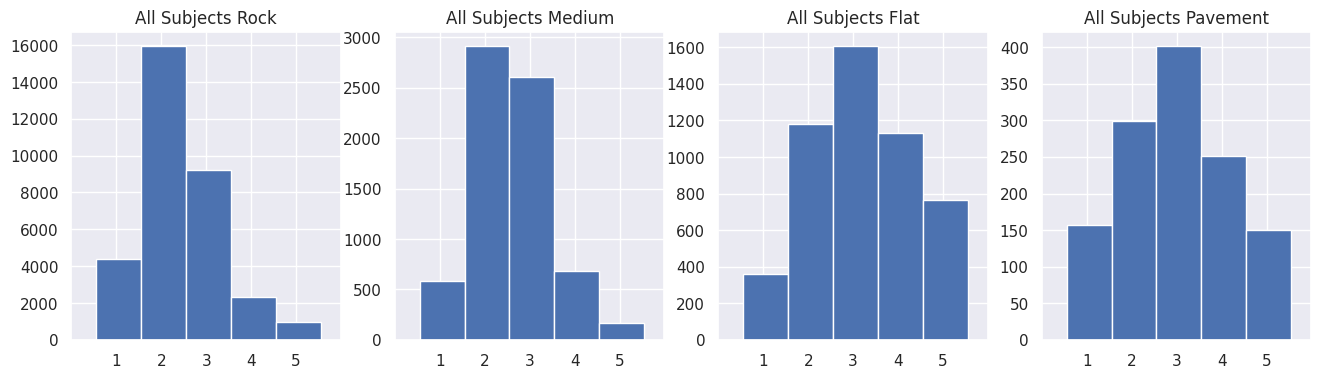

In [113]:
plt.figure(figsize=(16,4))


plt.subplot(1,4,1)
rel_foothold_fixation_allrock = np.hstack(rel_foothold_fixation_rock)
five_steps_rock = [x for x in rel_foothold_fixation_allrock if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_rock, bins= np.arange(np.nanmin(five_steps_rock)-.95,
               np.nanmax(five_steps_rock)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Rock')
    

plt.subplot(1,4,2)
rel_foothold_fixation_allmedium = np.hstack(rel_foothold_fixation_medium)
five_steps_medium = [x for x in rel_foothold_fixation_allmedium if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_medium, bins= np.arange(np.nanmin(five_steps_medium)-.95,
               np.nanmax(five_steps_medium)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Medium')


plt.subplot(1,4,3)
rel_foothold_fixation_allflat = np.hstack(rel_foothold_fixation_flat)
five_steps_flat = [x for x in rel_foothold_fixation_allflat if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_flat , bins= np.arange(np.nanmin(five_steps_flat )-.95,
               np.nanmax(five_steps_flat )+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Flat')



plt.subplot(1,4,4)
rel_foothold_fixation_allpavement = np.hstack(rel_foothold_fixation_pavement)
five_steps_pavement = [x for x in rel_foothold_fixation_allpavement if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_pavement , bins= np.arange(np.nanmin(five_steps_pavement )-.95,
               np.nanmax(five_steps_pavement )+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Pavement')

plt.show()

In [114]:
import json

with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_13_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_13_rocks_allWalks.json", "w") as f:
    json.dump(data,f)

In [115]:
data.keys()

dict_keys(['ww', 'splitWalks_date', 'walkType', 'eyes', 'frames', 'sessionID', 'takeID', 'subID', 'shadowMarkerNames', 'processData_date', 'framerate', 'legLength', 'calibDist', 'px2mmScale', 'rVorCalibErr', 'comXYZ', 'isThisVORCalibrationData', 'rGazeGroundIntersection', 'rEyeballCenterXYZ', 'rGazeXYZ', 'headVecX_fr_xyz', 'headVecY_fr_xyz', 'headVecZ_fr_xyz', 'shadow_fr_mar_dim', 'rHeelXYZ', 'rToeXYZ', 'rFootXYZ', 'lHeelXYZ', 'lToeXYZ', 'lFootXYZ', 'hTopXYZ', 'headXYZ', 'hCenXYZ', 'steps_HS_TO_StanceLeg_XYZ', 'syncedUnixTime', 'gaze_norm_pos_x', 'gaze_norm_pos_y', 'worldFrameIndex', 'headGlobalQuat_wxyz', 'rEye_theta', 'rEye_phi', 'rEye_norm_pos_x', 'rEye_norm_pos_y', 'rEye_circle_3d_radius', 'rEye_blinks', 'sesh', 'rCorrAlignTheta', 'corrAlignTheta'])

In [116]:
import glob
def rel_foothold_fixation_allSubjects(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    walkNum = walks    
    
    rel_foothold_fixation = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')    
        marker,skeleton,footholds,gazeGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        hips = np.squeeze(skeleton[:,1,:])
        print(data.keys())

        frame_edges = np.append(np.append(1,footholds[:,0]),gazeGround.shape[0]+1)
        frames_per_foothold = np.diff(frame_edges)
        current_foothold = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))

        distances = cdist(gazeGround,footholds[:,2:])
        closest_foothold = np.argmin(distances,axis=1)+1
        distances_min= np.min(distances, axis = 1)
        
        rff = np.where(distances_min > 0.4, np.nan, closest_foothold-current_foothold)
        rff = rff[data['fixationList'][:,0]]
        rel_foothold_fixation.append(rff)

    return rel_foothold_fixation

In [117]:
data = sio.loadmat('/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh/s3_19_pupilShadowMesh.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 'markerNames', 'shadow', 'step_plantfoot_xyz', 'y_flip', 'z_flip'])

In [118]:
data['fixationList'][:,0]

array([  1,   9,  22,  29,  34,  44,  45,  50,  61,  68,  69,  72,  76,
        86, 102, 117, 129, 145, 152, 156, 166, 176, 182, 188, 193, 202,
       208, 213, 229, 241, 247, 251, 252, 261, 274, 280, 282, 284, 285,
       291, 293, 302, 310, 317, 324, 345, 354, 363, 372, 388, 396, 399,
       403, 404, 405, 406, 407, 416, 420, 429, 430, 431, 442, 449, 459,
       464, 465, 470, 485, 493, 498, 508, 510, 514, 517, 519, 522, 525,
       527, 533], dtype=uint16)

In [120]:

def rel_foothold_fixation_allSubjects(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    walkNum = walks
    
    rel_foothold_fixation = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')    
        marker,skeleton,footholds,gazeGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        hips = np.squeeze(skeleton[:,1,:])

        frame_edges = np.append(np.append(1,footholds[:,0]),gazeGround.shape[0]+1)
        frames_per_foothold = np.diff(frame_edges)
        current_foothold = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))

        distances = cdist(gazeGround,footholds[:,2:])
        closest_foothold = np.argmin(distances,axis=1)+1
        distances_min= np.min(distances, axis = 1)
        
        rff = np.where(distances_min > 0.4, np.nan, closest_foothold-current_foothold)
        rel_foothold_fixation.append(rff)
    rel_foothold_fixation = np.hstack(rel_foothold_fixation)
    return rel_foothold_fixation


In [119]:
rocks = rel_foothold_fixation_allSubjects(3,'rock')

nanmax = np.nanmax(rocks[0])
nanmin = np.nanmin(rocks[0])

print(nanmin)
print(nanmax)


fmax = 6
count = np.zeros((fmax + 2, fmax +2 ))

for r1, r2 in zip(rocks[0][:-2],rocks[0][1:]):
    if r1 > fmax or np.isnan(r1):
        r1 = fmax + 1
    if r2 > fmax or np.isnan(r2):
        r2 = fmax + 1
    count[int(r1),int(r2)] += 1
count[0][1] = -1
print(count)
   

dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 'markerNames', 'shadow', 'step_plantfoot_xyz', 'y_flip', 'z_flip'])
dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 'markerNames', 'shadow', 'step_plantfoot_xyz', 'y_flip', 'z_flip'])
dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 'markerNames', 'shadow', 'step_plantfoot_xyz', 'y_flip', 'z_flip'])
dict_keys(['__header__', '__version__', '__globals__', 'allPoints', 'cens', 'closestActualIndexDist', 'closestPrefIndexDist', 'eyeVec', 'fixBool', 'fixationList', 'frame_prefStepNum_XYZ', 'gazeXYZ', 